### 리샘플링

리샘플링(resampling)은 포트폴리오 모델링에서 사용되는 기술로, 포트폴리오의 통계적 특성을 추정하는 데 사용됩니다. 이는 역사적인 데이터의 하위 집합을 무작위로 선택하고, 이 하위 집합의 데이터를 사용하여 포트폴리오의 수익률을 분석하는 것을 포함합니다. 이 과정은 여러 번 반복되어 가능한 결과의 분포를 얻습니다.

포트폴리오 모델링에서 일반적으로 사용되는 리샘플링 방법 중 하나는 몬테카를로 시뮬레이션(Monte Carlo simulation)입니다. 몬테카를로 시뮬레이션은 포트폴리오의 자산들의 역사적인 수익률을 사용하여 많은 수의 모의 수익률을 생성합니다. 이 모의 수익률을 사용하여 포트폴리오 수익률의 평균과 분산을 계산할 수 있으며, 이를 사용하여 포트폴리오의 위험과 수익을 추정할 수 있습니다.

포트폴리오 모델링에서 사용되는 또 다른 리샘플링 방법은 부트스트래핑(bootstrapping)입니다. 부트스트래핑은 역사적인 수익률에서 데이터를 무작위로 선택하고, 이를 사용하여 새로운 샘플을 생성합니다. 이 새로운 샘플을 사용하여 포트폴리오 수익률의 평균과 분산을 계산하고, 이를 사용하여 포트폴리오의 위험과 수익을 추정할 수 있습니다.

리샘플링은 포트폴리오 매니저가 포트폴리오의 잠재적인 위험과 기회를 식별하는 데 도움을 줄 수 있습니다. 다양한 시장 시나리오를 시뮬레이션하여, 리샘플링은 포트폴리오가 다양한 시장 조건에서 어떻게 수행될 수 있는지에 대한 통찰력을 제공할 수 있습니다. 또한, 자산 배분 전략이 포트폴리오의 위험과 수익에 미치는 영향을 평가하는 데 사용될 수 있습니다.

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

sns.set()

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

etf = yf.Tickers(tickers)

data = etf.history(start='2011-01-01', actions=False)

data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)

data.droplevel(0, axis=1)

[*********************100%***********************]  9 of 9 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2011-01-03,30.168968,45.762096,10.574046,27.754164,21.301199,21.268747,20.726185,25.937012,32.382439
2011-01-04,29.966396,45.369431,10.561069,27.714651,21.384844,21.210770,20.824911,26.018599,32.202766
2011-01-05,30.036518,45.549141,10.684330,27.856901,21.510286,21.218018,20.693281,26.075712,32.467995
2011-01-06,29.880672,45.116531,10.612967,27.809484,21.635735,21.145550,20.713018,26.181786,32.271225
2011-01-07,29.849518,45.442654,10.522149,27.864801,21.535374,21.036850,20.785419,26.165462,32.254093
...,...,...,...,...,...,...,...,...,...
2023-02-13,82.459999,89.980003,36.910000,103.070000,142.809998,73.800003,68.120003,133.589996,150.320007
2023-02-14,82.650002,90.010002,36.709999,102.790001,143.419998,73.129997,67.830002,132.800003,152.119995
2023-02-15,83.010002,88.480003,36.750000,103.430000,144.089996,73.269997,68.269997,132.139999,153.899994


In [3]:
# 수익률
rets = data.pct_change().fillna(0)

# 수익률 벡터
ret_vec = rets.mean() * 252

# 공분산 행렬
cov_mat = rets.cov() * 252

In [4]:
# 효율적 경계선 리샘플링 함수
def resampled_efficient_frontier(ret_vec, cov_mat, size=252, N_path=50, N_point=50, resampling=True):
    '''
    Parameters
    ==========
    size : int
        기간, 랜덤 추출 샘플 갯수
    N_path : int
        시뮬레이션 횟수
    N_point : int
        효율적 경계선 타겟 수익률 갯수
    
    '''

    # 자산 갯수
    n = len(ret_vec)

    if resampling:
        # 리샘플링을 위한 시뮬레이션
        ret_vec_stack = np.zeros((N_path, len(ret_vec)))    # 시뮬레이션 번호와 수익률 벡터를 담을 수 있는 2차원 배열
        cov_mat_stack = np.zeros((N_path, len(ret_vec), len(ret_vec)))  # 시뮬레이션 번호와 공분산 행렬을 담을 수 있는 3차원 배열
    
        for i in range(N_path):
            # 리샘플링 셩로 생성
            # 다변량 정규분포로부터 임의의 난수 추출
            data = np.random.multivariate_normal(ret_vec, cov_mat, size=size)

            # 새롭게 만들어진 기대수익률 벡터
            ret_vec_i = data.mean(axis=0)
            ret_vec_stack[i, :] = ret_vec_i

            # 새롭게 만들어진 공분산 행렬
            cov_mat_i = np.cov(data.T)
            cov_mat_stack[i, :, :] = cov_mat_i
        
        # 새로 업데이트 된 기대수익률 벡터와 공분산 행렬
        new_ret_vec = ret_vec_stack.mean(axis=0)
        new_cov_mat = cov_mat_stack.mean(axis=0)
    
    else:
        new_ret_vec = ret_vec
        new_cov_mat = cov_mat
    

    # 목적함수
    def obj_func(weights):

        # 투자 가중치
        weights = np.array(weights)

        # 포트폴리오 변동성
        pvol = np.sqrt(np.dot(weights.T, np.dot(new_cov_mat, weights)))

        return pvol
    
    # 수익률 수준별 포트폴리오 최적화 수행
    trets = np.linspace(0.1, 0.15, N_point)
    tvols = []

    # 난수를 활용해 임의의 가중치 데이터 생성
    weights = np.random.random(n)
    weights /= np.sum(weights)

    # 각 목표 수익률에 맞는 포트폴리오 변동성 레벨을 계산
    for tret in trets:

        # 투자 가중치 초기값 = 균등 가중치
        init_guess = np.repeat(1/n, n)

        # 제약조건 (포트폴리오 목표 수익률, 현금 보유 비중 0)
        cons = ({'type': 'eq', 'fun': lambda x: np.array(np.sum(new_ret_vec * x)) - tret},      # 포트폴리오 목표 수익률과 타겟 수익률 동등
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # 자산별 경계조건 (숏 포지션 불가능)
        bnds = tuple((0.0, 1.0) for x in weights)

        # 최적화 알고리즘 수행
        res = sco.minimize(obj_func,
                            init_guess,
                            method='SLSQP',
                            bounds=bnds,
                            constraints=cons)

        # 최적화 알고리즘을 통해 찾아낸 최적 포트폴리오의 변동성 값을 리스트에 저장
        tvols.append(res['fun'])

    # 포트폴리오 변동성 리스트를 배열로 변환
    tvols = np.array(tvols) 

    # 결과값 반환
    return trets, tvols     

        

In [5]:
# 리샘플링 O
new_trets, new_tvols = resampled_efficient_frontier(ret_vec, cov_mat)

# 리샘플링 X
trets, tvols = resampled_efficient_frontier(ret_vec, cov_mat, resampling=False)

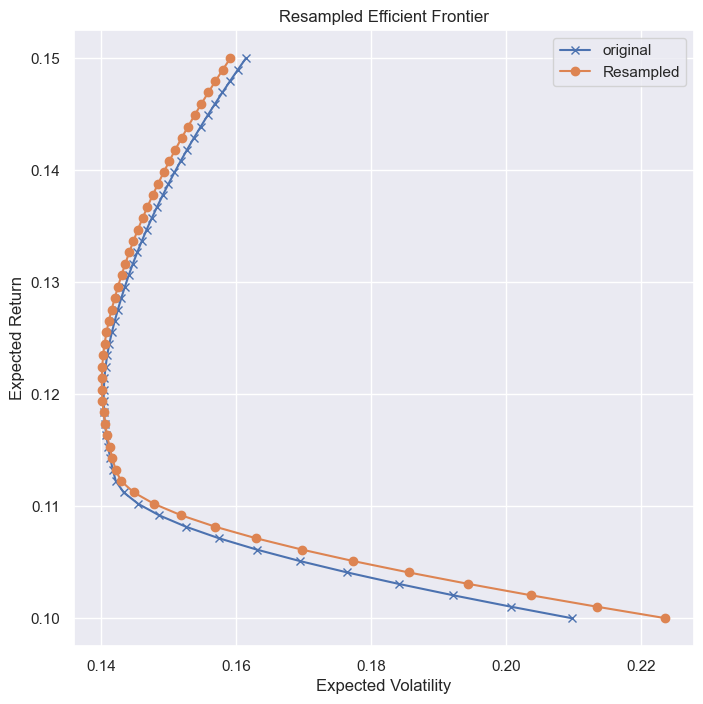

In [6]:
# 리샘플링 효율적 경계선 시각화
plt.figure(figsize=(8, 8))
plt.plot(tvols, trets, marker='x', label='original')
plt.plot(new_tvols, new_trets, marker='o', label='Resampled')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Resampled Efficient Frontier')
plt.legend()